In [5]:
## IMPORTS ##
import pandas as pd
import os
import shutil
from PIL import Image
from pathlib import Path
from collections import Counter
import numpy as np
import random
from scipy.ndimage import rotate
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
### RAW FILE DIRECTORIES ###
CSV_PATH = 'datasets.csv'
RAW_DIRECTORY = 'datasets-PNG'

In [6]:
## LOAD AND SEPARATE ##

def sort_and_analyze(csv_path, image_dir, output_base_dir):
    df = pd.read_csv(csv_path)
    normal_dir = os.path.join(output_base_dir, 'normal')
    diseased_dir = os.path.join(output_base_dir, 'diseased')

    for dir_path in [normal_dir, diseased_dir]:
        os.makedirs(dir_path, exist_ok=True)
    
    dimensions = []
    classification_counts = Counter()
    print('Starting...')
    for _, row in df.iterrows():
        number = f"{int(row['Number']):04d}"
        image_files = list(Path(image_dir).glob(f"{number}*"))
        if not image_files:
            print(f"Warning: no image found for number {number}")
            continue

        image_path = image_files[0]

        if row['Disease classification: 1. Cervical spondylosis; 2. Healthy'] == 2:
            target_dir = normal_dir
            classification_counts['normal'] += 1
        else:
            target_dir = diseased_dir
            classification_counts['diseased'] += 1

        shutil.copy2(image_path, os.path.join(target_dir, image_path.name))

        with Image.open(image_path) as img:
            dimensions.append(img.size)

    print('Done!')
    unique_dimensions = set(dimensions)
    dimension_counts = Counter(dimensions)

    print("\nImage Analysis Results:")
    print("-----------------------")
    print(f"Total images processed: {len(dimensions)}")
    print(f"\nClass distribution:")
    print(f"Normal: {classification_counts['normal']}")
    print(f"Diseased: {classification_counts['diseased']}")
    
    print(f"\nUnique image dimensions found: {len(unique_dimensions)}")
    print("\nDimension breakdown:")
    for dim, count in dimension_counts.items():
        print(f"{dim}: {count} images")
    
    if len(unique_dimensions) > 1:
        print("\nWARNING: Not all images have the same dimensions!")
    
    return classification_counts, dimension_counts

csv_path = CSV_PATH
image_dir = RAW_DIRECTORY
output_base_dir = ''

counts, dimensions = sort_and_analyze(csv_path, image_dir, output_base_dir)

Starting...
Done!

Image Analysis Results:
-----------------------
Total images processed: 4963

Class distribution:
Normal: 181
Diseased: 4782

Unique image dimensions found: 2717

Dimension breakdown:
(802, 1014): 1 images
(691, 1012): 1 images
(848, 1012): 1 images
(774, 1010): 2 images
(772, 1010): 2 images
(691, 1010): 1 images
(684, 1012): 1 images
(772, 1014): 1 images
(779, 1014): 2 images
(742, 1063): 1 images
(769, 1003): 1 images
(779, 1010): 1 images
(887, 998): 1 images
(873, 1063): 1 images
(711, 1007): 1 images
(744, 1003): 1 images
(698, 1005): 1 images
(862, 1005): 1 images
(1028, 1012): 1 images
(938, 1012): 1 images
(767, 1014): 2 images
(709, 1007): 1 images
(760, 1017): 1 images
(820, 1021): 1 images
(799, 1014): 1 images
(862, 1014): 1 images
(850, 1017): 1 images
(867, 1012): 1 images
(767, 1012): 1 images
(776, 1014): 1 images
(700, 1012): 2 images
(792, 1012): 1 images
(774, 1019): 1 images
(748, 1007): 1 images
(811, 1007): 1 images
(751, 1010): 1 images
(721,

In [7]:
## RESIZE, AUGMENT ##

def find_common_size(image_dir):
    sizes = []
    for img_path in Path(image_dir).glob('*.*'):
        with Image.open(img_path) as img:
            sizes.append(img.size)
    return max(set(sizes), key=sizes.count)

def resize_and_pad(image, target_size):
    if image.mode != 'L':
        image = image.convert('L')
    
    target_width, target_height = target_size
    width, height = image.size

    ratio = min(target_width/width, target_height/height)
    new_size = (int(width*ratio), int(height*ratio))

    image = image.resize(new_size, Image.Resampling.LANCZOS)

    new_image = Image.new('L', target_size, 0)

    paste_x = (target_width - new_size[0]) // 2
    paste_y = (target_height - new_size[1]) //2
    new_image.paste(image, (paste_x, paste_y))

    return new_image

def apply_augmentation(image, max_rotation=10, max_shift=20, noise_factor=0.05):
    img_array = np.array(image)

    angle = random.uniform(-max_rotation, max_rotation)
    img_array = rotate(img_array, angle, reshape=False, mode='constant', cval=0)

    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    shifted = np.zeros_like(img_array)

    if shift_x >= 0:
        shifted[shift_x:, :] = img_array[:-shift_x, :] if shift_x > 0 else img_array
    else:
        shifted[:shift_x, :] = img_array[-shift_x:, :]
        
    if shift_y >= 0:
        shifted[:, shift_y:] = img_array[:, :-shift_y] if shift_y > 0 else img_array
    else:
        shifted[:, :shift_y] = img_array[:, -shift_y:]

    noise = np.random.normal(0, noise_factor * np.mean(shifted), shifted.shape)
    final_img = np.clip(shifted + noise, 0, 255).astype(np.uint8)
    
    return Image.fromarray(final_img)

def process_dataset(normal_dir, diseased_dir, output_base_dir, target_size, augmentations_per_image=8):
    output_normal = os.path.join(output_base_dir, 'normal')
    output_diseased = os.path.join(output_base_dir, 'diseased')
    os.makedirs(output_normal, exist_ok=True)
    os.makedirs(output_diseased, exist_ok=True)

    print("processing diseased images")
    diseased_features = []
    for img_path in tqdm(list(Path(diseased_dir).glob('*.*'))):
        with Image.open(img_path) as img:
            resized = resize_and_pad(img, target_size)
            output_path = os.path.join(output_diseased, img_path.name)
            resized.save(output_path)
            diseased_features.append(np.array(resized).flatten())

    print('processing and augmenting normal images...')
    normal_features = []
    for img_path in tqdm(list(Path(normal_dir).glob('*.*'))):
        with Image.open(img_path) as img:
            resized = resize_and_pad(img, target_size)
            output_path = os.path.join(output_normal, img_path.name)
            resized.save(output_path)
            normal_features.append(np.array(resized).flatten())

            for i in range(augmentations_per_image):
                augmented = apply_augmentation(resized)
                aug_path = os.path.join(output_normal, f"{img_path.stem}_aug{i}{img_path.suffix}")
                augmented.save(aug_path)
                normal_features.append(np.array(augmented).flatten())
    
    return np.array(normal_features), np.array(diseased_features)

normal_dir = 'normal'
diseased_dir = 'diseased'
output_dir = 'new-dataset-proccessed'

target_size = find_common_size(diseased_dir)
print(f"Target Size: {target_size}")

normal_features, diseased_features = process_dataset(
    normal_dir,
    diseased_dir,
    output_dir,
    target_size,
    augmentations_per_image=8
)

Target Size: (567, 746)
processing diseased images


 10%|▉         | 470/4782 [00:37<05:44, 12.52it/s]


KeyboardInterrupt: 

loading normal images...


100%|██████████| 1810/1810 [00:08<00:00, 208.91it/s]


loading diseased images...


100%|██████████| 4782/4782 [00:23<00:00, 202.12it/s]


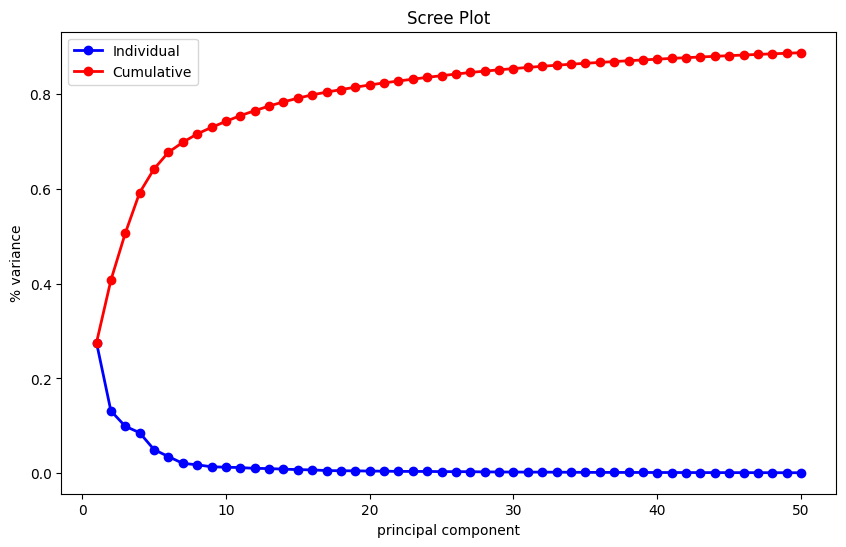

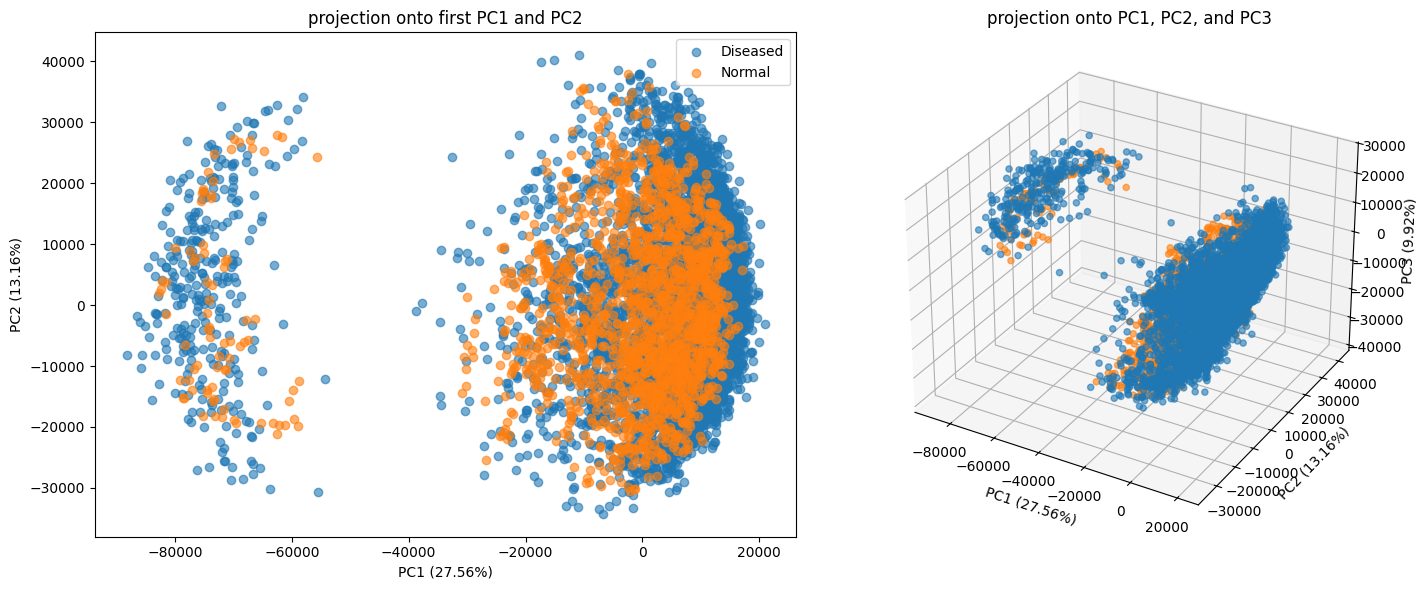


Cumulative variance explained:
First 1 components: 27.560%
First 2 components: 40.721%
First 3 components: 50.640%


In [3]:
## PCA ##

def load_processed_data(normal_dir, diseased_dir):
    features, labels = [], []

    print("loading normal images...")
    for img_path in tqdm(list(Path(normal_dir).glob('*.*'))):
        with Image.open(img_path) as img:
            features.append(np.array(img).flatten())
            labels.append('Normal')

    print("loading diseased images...")
    for img_path in tqdm(list(Path(diseased_dir).glob('*.*'))):
        with Image.open(img_path) as img:
            features.append(np.array(img).flatten())
            labels.append('Diseased')
    
    return np.array(features), np.array(labels)

def create_scree(features):
    pca = PCA(n_components=min(50, features.shape[1]))
    pca.fit(features)

    plt.figure(figsize=(10,6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             pca.explained_variance_ratio_, 'bo-', linewidth=2)
    
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             np.cumsum(pca.explained_variance_ratio_), 'ro-', linewidth=2)
    
    plt.xlabel('principal component')
    plt.ylabel('% variance')
    plt.title('Scree Plot')
    plt.legend(['Individual', 'Cumulative'])

    return plt, pca

def plot_pca(features, labels):
    pca = PCA(n_components=3)
    transformed = pca.fit_transform(features)

    fig = plt.figure(figsize=(15,6))

    ax1 = fig.add_subplot(121)
    for label in np.unique(labels):
        mask = labels == label
        ax1.scatter(transformed[mask, 0], transformed[mask, 1], label=label, alpha=0.6)
    ax1.set_title('projection onto first PC1 and PC2')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax1.legend()

    ax2 = fig.add_subplot(122, projection='3d')
    for label in np.unique(labels):
        mask = labels == label
        ax2.scatter(transformed[mask, 0], transformed[mask, 1], transformed[mask, 2],
                    label=label, alpha=0.6)
    ax2.set_title('projection onto PC1, PC2, and PC3')
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')

    plt.tight_layout()
    return plt, pca

normal_dir = 'new-dataset-proccessed/normal'
diseased_dir = 'new-dataset-proccessed/diseased'

features, labels = load_processed_data(normal_dir, diseased_dir)

screeplot, scree_pca = create_scree(features)
screeplot.show()

pcaplot, pca = plot_pca(features, labels)
pcaplot.show()

print("\nCumulative variance explained:")
cumsum = np.cumsum(pca.explained_variance_ratio_)
for i, sum_var in enumerate(cumsum[:10], 1):
    print(f"First {i} components: {sum_var:.3%}")
